# FLIP

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/grids/FLIP.ipynb)

This example simulates a liquid using the fluid implicit particle (FLIP) method.

In [1]:
%pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from phi.field._point_cloud import distribute_points
from tqdm.notebook import trange

We begin by defining the domain, obstacles, and initial fluid particles.

<Figure size 864x360 with 1 Axes>

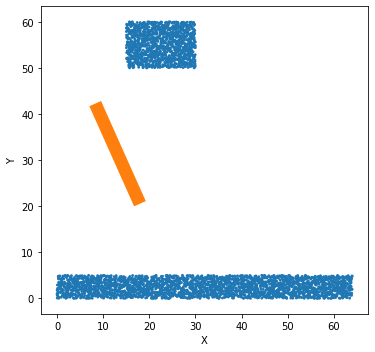

In [103]:
domain = Box(x=64, y=64)
obstacle = Box(x=(1, 25), y=(30, 33)).rotated(-20)
initial_particles = distribute_points(union(Box(x=(15, 30), y=(50, 60)), Box(x=None, y=(-INF, 5))), x=64, y=64) * (0, 0)
plot(initial_particles.geometry, obstacle, overlay='args')

In each simulation step, we find the velocity field and occupancy mask on a regular grid.
This allows us to perform a grid-based pressure solve.
The pressure forces can then be mapped back to the particles before updating the positions according to the velocity and boundaries.

In [98]:
@jit_compile
def step(particles: Field, pressure=None, dt=.1, gravity=vec(x=0, y=-9.81)):
    # --- Grid Operations ---
    grid_v = prev_grid_v = field.finite_fill(particles.at(StaggeredGrid(0, 0, domain, x=64, y=64), scatter=True, outside_handling='clamp'))
    occupied = resample(field.mask(particles), CenteredGrid(0, grid_v.extrapolation.spatial_gradient(), grid_v.bounds, grid_v.resolution), scatter=True, outside_handling='clamp')
    grid_v, pressure = fluid.make_incompressible(grid_v + gravity * dt, [obstacle], active=occupied)
    # --- Particle Operations ---
    particles += resample(grid_v - prev_grid_v, to=particles)  # FLIP update
    # particles = resample(grid_v, particles)  # PIC update
    particles = advect.points(particles, grid_v * resample(~obstacle, to=grid_v), dt, advect.finite_rk4)
    particles = fluid.boundary_push(particles, [obstacle, ~domain], separation=.5)
    return particles, pressure

Let's run the simulation!

In [101]:
part_trj, p_trj = iterate(step, batch(time=100), initial_particles, None, substeps=2)

In [102]:
plot(resample(p_trj, to=part_trj.time[:-1]), obstacle, overlay='args', animate='time')